## Overview
In this report, we analyze a dataset that provides information on bicycle traffic across New York City’s four East River Bridges during 2016. The dataset is composed of daily samples taken between April and October and is organized into columns, including: date, day of week, high temperature, low temperature, precipitation, Brooklyn Bridge, Manhattan Bridge, Williamsburg Bridge, Queensboro Bridge, and total. The values within each bridge column represent the number of bicyclists that crossed the bridge on the day sampled. The total column represents the sum of all four bridge columns. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from textwrap import wrap

dataset_2 = pd.read_csv('NYC_Bicycle_Counts_2016.csv')
df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge','Total']]
df = df.apply(lambda x: x.str.replace(',', '')).astype(float) #Pulls out commas from values and casts to float

## Question 1
**You want to install sensors on the bridges to estimate overall traffic across all the bridges. But you only have enough budget to install sensors on three of the four bridges. Which bridges should you install the sensors on to get the best prediction of overall traffic?**

In order to determine which bridges we should install the sensors on, we must first examine the relationship between bicycle usage on each bridge and bicycle usage on all bridges. This can be accomplished by calculating the Pearson correlation coefficients for each bridge's bike traffic and overall traffic. Pearson correlation coefficients allow us to assess the strength and direction of association between two variables. These values range from [-1,1]; -1 indicating a perfectly inverse relationship and 1 indicating a perfectly linear relationship. In order to capture the best representation of overall bike traffic, the sensors should be placed on the three bridges with the greatest coefficients. 

Based on our dataset, we hypothesized that the Manhattan, Williamsburg, and Queensboro bridges would have the strongest correlation coefficients. A simple eye-test on the data set revealed that the Brooklyn Bridge seemed to consistently contain the least amount of traffic among the four bridges. This suspicion was confirmed as the Brooklyn Bridge recorded the smallest number of bicyclists in 93% (199/214) of the dates sampled. This is a clear indication that it will have the weakest correlation coefficient with overall bike traffic.

It may also be useful to calculate the correlation coefficients between each of the four bridges to determine if their activity levels are independent of each other. This would provide us with a better understanding of the interdependence of bike traffic patterns across all bridges. If the activity on one bridge is highly correlated with the activity on another bridge, placing a sensor on only one may be sufficient to model the activity of both.




#### Bridge/Total Correlation 

The results shown in the following figure align with our prediction that the bike traffic on the Brooklyn Bridge would have the weakest correlation coefficient with overall bike traffic. This means that of the four bridges, the bike traffic on the Brooklyn Bridge has the least significant impact on total bike traffic. While it may be tempting to install the sensors on the other three bridges, it is important we also assess the correlation among the four bridges themselves. 

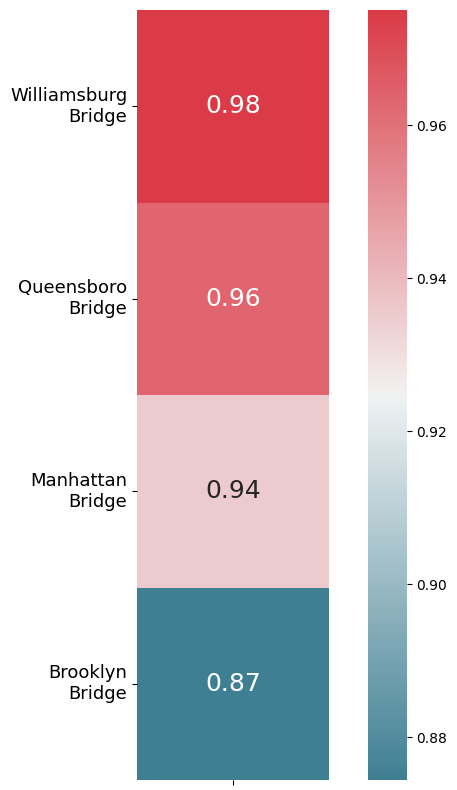

In [2]:
df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge','Total']]
df = df.apply(lambda x: x.str.replace(',', '')).astype(float) 
cm = df.corr(method = "pearson")
#Sorts the dataframe in descending order so its nicer to look at 
corr_w_total = pd.DataFrame(cm.loc['Total'][:-1]).sort_values(by = 'Total', ascending = False)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_w_total, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True,square = True, annot_kws={"fontsize":18})

#wraps the labels so they're easier to read 
labels = ['\n'.join(wrap(label,12)) for label in ['Williamsburg Bridge', 'Queensboro Bridge', 'Manhattan Bridge', 'Brooklyn Bridge']] 
ax.set_yticklabels(labels, rotation=0, va="center", fontsize = 13)

ax.set_xticklabels([]) #removes total from X axis bc that will be in figure caption 
plt.show()

#### Bridge Correlation Matrix 

The following figure indicates that the bridges with the weakest correlation are Brooklyn and Manhattan (r = 0.75) and the bridges with the strongest correlation are Queensboro and Williamsburg (r = 0.97). This discrepancy can potentially be attributed to the fact that the Queensboro and Williamsburg bridges are not located in close proximity to each other or any other bridges. Conversely, the Brooklyn and Manhattan bridges are located within very close proximity. This could mean that bike traffic on the Queensboro bridge and Williamsburg bridge is influenced more by the overall traffic patterns of the city, while the bike traffic on the Brooklyn bridge and Manhattan bridge is influenced more by local traffic patterns. 



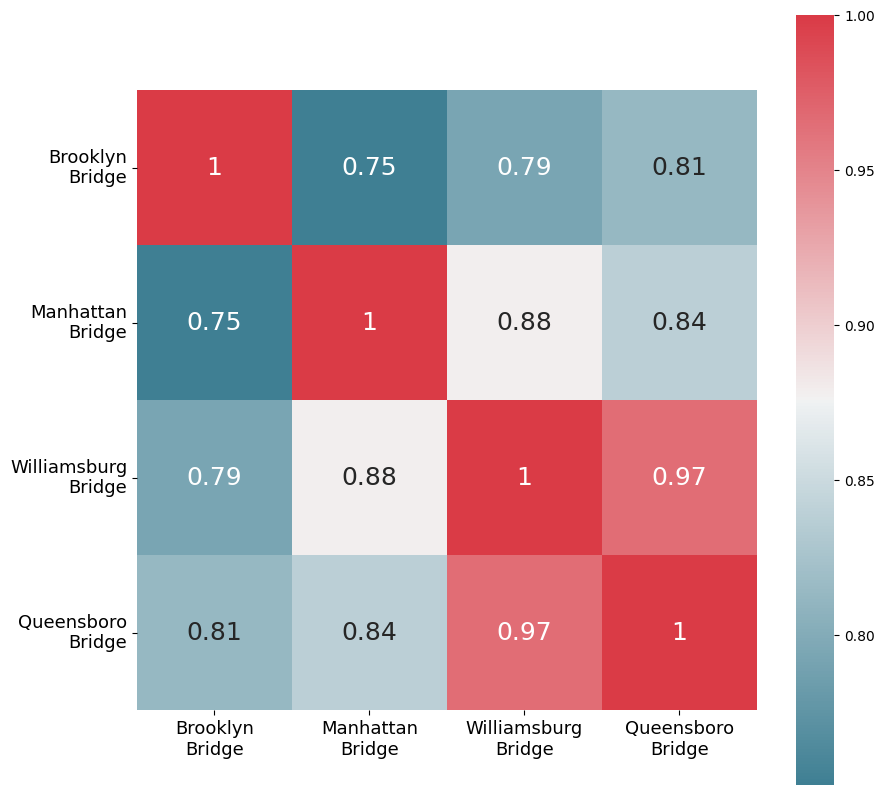

In [3]:
df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge','Total']]
df = df.apply(lambda x: x.str.replace(',', '')).astype(float) 
columns = ['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge']
df = df[columns]
corr_matrix = df.corr(method = 'pearson') 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, square=True, ax=ax, annot_kws={"fontsize":18})

labels = ['\n'.join(wrap(label,12)) for label in columns] #wraps the labels so they're easier to read 
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize = 13)
ax.set_yticklabels(labels, rotation=0, va="center", fontsize = 13)
plt.show()

#### Bridge Box Plots 
The similar distributions of the boxplots for the Queensboro Bridge and the Williamsburg Bridge align with this conjecture.

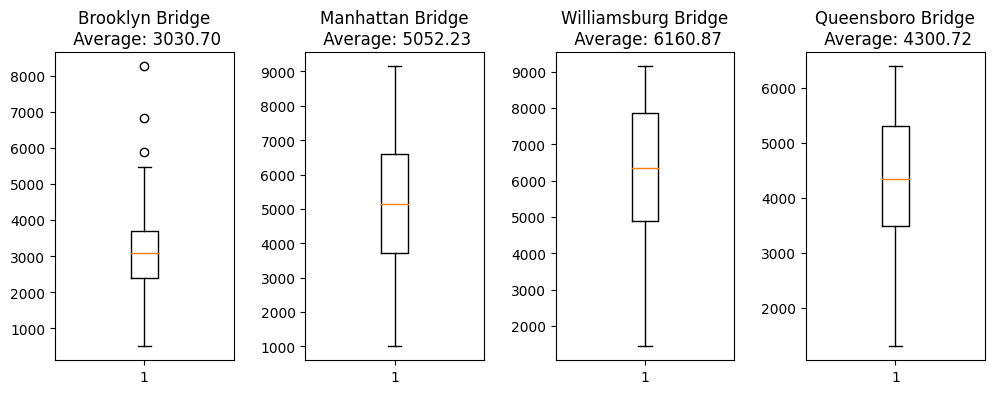

In [4]:
column_averages = df.mean()
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].boxplot(df['Brooklyn Bridge'])
axs[0].set_title(f"Brooklyn Bridge\n Average: {column_averages['Brooklyn Bridge']:.2f}")
axs[1].boxplot(df['Manhattan Bridge'])
axs[1].set_title(f"Manhattan Bridge\n Average: {column_averages['Manhattan Bridge']:.2f}")
axs[2].boxplot(df['Williamsburg Bridge'])
axs[2].set_title(f"Williamsburg Bridge\n Average: {column_averages['Williamsburg Bridge']:.2f}")
axs[3].boxplot(df['Queensboro Bridge'])
axs[3].set_title(f"Queensboro Bridge\n Average: {column_averages['Queensboro Bridge']:.2f}")
plt.subplots_adjust(wspace=0.4)

plt.show()

#### Sampling Distributions of Correlation Coefficients 
For further investigation, a sampling distribution was created for both values. When two sampling distributions of correlation coefficients have very little overlap, it indicates that there is a significant difference between the relationships each coefficient represents. However, mere observation is not sufficient to draw definitive conclusions. A hypothesis test is necessary to determine whether or not this observed difference is statistically significant. 


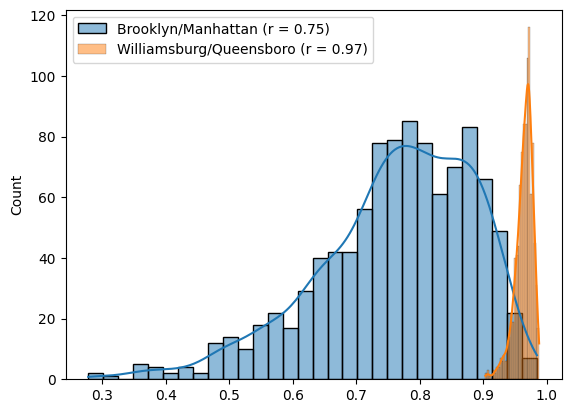

In [5]:
df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge','Total']]
df = df.apply(lambda x: x.str.replace(',', '')).astype(float) 
b_bridge = df['Brooklyn Bridge'] 
m_bridge = df['Manhattan Bridge']
w_bridge = df['Williamsburg Bridge']
q_bridge = df['Queensboro Bridge']

n = 1000 #num samples
fraction = 0.5
ss = int(len(df) * fraction) #sample size

#List comprehension to sample the columns n times and use pandas .corr method to return the coefficients of the sample to the list 
b_m_data = [(b_bridge.sample(n=ss,replace=True)).corr(m_bridge.sample(n=ss,replace=True), method = 'pearson') for i in range(n)] 
w_q_data = [(w_bridge.sample(n=ss,replace=True)).corr(q_bridge.sample(n=ss,replace=True), method = 'pearson') for i in range(n)]

#kde = True passed to show PDF of each histogram, makes it easier to see length of tails 
sns.histplot(b_m_data, bins=30, kde=True, label = "Brooklyn/Manhattan (r = 0.75)" ) 
sns.histplot(w_q_data, bins=30, kde=True, label = "Williamsburg/Queensboro (r = 0.97)") 

plt.legend()
plt.show()

#### Hypothesis Test

Despite having a sufficient sample size for the Central Limit Theorem to hold, the sampling distribution of Pearson correlation coefficients will generally never reflect that of a normal distribution. This is due to the fact that these values are bounded by -1 and 1, so a strong positive coefficient will likely have a negative skew, and vice versa. This is reflected in the sampling distributions shown in the previous figure.

In order to make a more accurate comparison of our values, we must first use the Fisher transformation to convert them to variables that are normally distributed with a known standard error. 

$$Z'\:=\:\frac{1}{2}ln\left(\frac{1+r}{1-r}\right)$$

$$SE\:=\:\frac{1}{\sqrt{N-3}}$$

This allows us to conduct a simple two-sample z-test:

$$Close\:Proximity\:Group\left(Brooklyn+Manhattan\right):\:r_1=0.7517,\:Z'_1=0.9768$$
$$Only\:Bridges\:Group\left(Williamsburg+Queensboro\right):\:r_2=0.9654,\:Z'_2=2.0198$$

Null Hypothesis $\left(Z'_1=Z'_2\right)$: There is no significant difference in the correlation coefficient between bridges located in close proximity to each other and those that are the only bridges in their respective regions.


Alternative Hypothesis $\left(Z'_1≠Z'_2\right)$: There is a significant difference in the correlation coefficient between bridges located in close proximity to each other and those that are the only bridges in their respective regions.

$$SE=\sqrt{\left(\frac{1}{N_1-3}\right)+\left(\frac{1}{N_2-3}\right)}=0.0973$$

$$Z\:=\:\frac{\left(Z'_1-Z'_2\right)}{SE}=-10.719$$

The computed p-value from our Z score is $<.00001$. Since this value falls well below a significance level of $0.05$, we reject the null hypothesis and conclude that there is a significant difference in the correlation coefficient between bridges located in close proximity to each other and those that are the only bridges in their respective regions. This means that it is highly improbable that the discrepancy between the coefficients can be attributed to chance.



#### The Imaginary Bridge
Based on the results of our hypothesis test, we conducted further analysis to explore the discrepancy. Specifically, we created an imaginary bridge by summing the traffic volumes of the Manhattan and Brooklyn bridges. According to our theory, the imaginary bridge would fall under the “Only Bridge Group” and therefore should yield a stronger correlation than both the Manhattan Bridge and Brooklyn Bridge when compared to either the Williamsburg Bridge and the Queensboro Bridge. The results of this experiment are as expected. The figure below shows that the combined traffic volume of the Imaginary bridge has a stronger correlation with both other bridges than either bridge alone. This provides further evidence to support our theory that the correlation between bridges is driven by the availability of alternative options for the cyclists. 


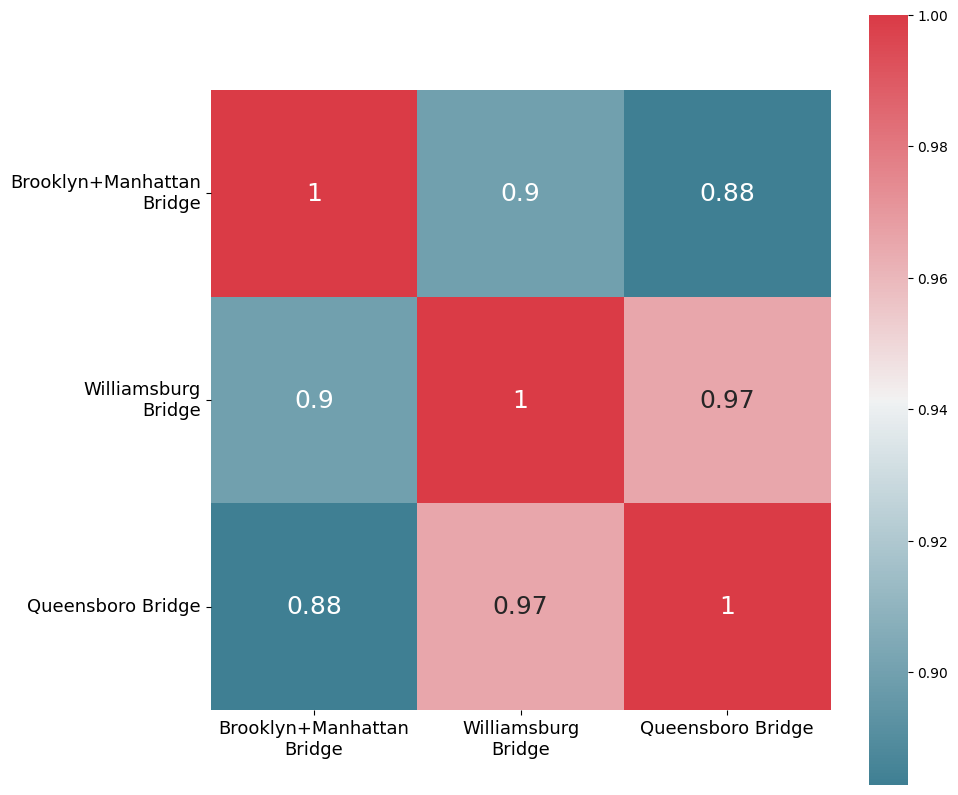

In [6]:
df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge','Total']]
df = df.apply(lambda x: x.str.replace(',', '')).astype(float) 
columns = ['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge']
df1 = df[columns]
df1['Brooklyn+Manhattan Bridge'] = df['Manhattan Bridge'] + df['Brooklyn Bridge'] #Summing columns to represent imaginary bridge 
corr_matrix1 = df1[['Brooklyn+Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge' ]].corr(method = 'pearson') 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix1, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, square=True, ax=ax, annot_kws={"fontsize":18})
labels = ['\n'.join(wrap(label,18)) for label in ['Brooklyn+Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge' ]]
ax.set_xticklabels(labels, rotation=0, ha="center", fontsize = 13)
ax.set_yticklabels(labels, rotation=0, va="center", fontsize = 13)
plt.show()

#### Question 1 Final Answer

To get the best prediction of overall traffic, the three sensors must be placed on the Manhattan Bridge, Brooklyn Bridges, and Williamsburg Bridge. Despite the correlation coefficient between the Brooklyn Bridge bike traffic and total bike traffic being the lowest, it is still necessary that it receives a sensor to get a more comprehensive representation of traffic patterns. If a sensor were to be placed only on the Manhattan bridge and traffic levels are observed to decrease, there would be no way of determining whether simply fewer cyclists are crossing or if those cyclists are crossing over the Brooklyn bridge instead. The strong correlation between bike traffic on the Williamsburg bridge and bike traffic on the Queensboro Bridge allows us to place a sensor on one, and use its data to model the activity of the other. The Williamsburg bridge was chosen over the Queensboro due to its stronger correlation with the total activity. 


## Question 2
**The city administration is cracking down on helmet laws, and wants to deploy police officers on days with high traffic to hand out citations. Can they use the next day's weather forecast(low/high temperature and precipitation) to predict the total number of bicyclists that day?**


The correct approach for determining whether the next day’s weather forecast can be used  to predict the total number of bicyclists that day is regression analysis. This is because our goal is to predict a continuous target variable (total number of bicyclists) based on predictor variables (next day’s weather forecast). Regression models are designed to capture the relationship between predictor variables and the target variable, allowing us to make predictions on new data. Linear regression is a fairly straightforward model that assumes a linear relationship between the features and the target variable. It is often a good starting point for problems like these as it can provide a baseline for comparison with more complex models. 

An even better starting place would be to create scatter plots of the features so we can visually inspect relationships between our predictor variables and target variables. They help you identify any linear or non-linear patterns in the data, as well as any outliers that may impact your choice of model. We predicted that if we’re able to identify any trends within our initial exploration of the data, the police should be able to use the next day’s weather forecast to predict the total number of bicyclists. 

#### Scatter Plots 
The first scatter plot in the figure below indicates that there is a weak positive relationship between the daily maximum and minimum temperatures. However, given that these two variables are interconnected, it's unclear whether the total number of bicyclists is impacted by just the daily maximum temperature, or both the daily maximum temperature and daily minimum temperature. The second plot is more easily interpretable. There appears to be no correlation between the level of precipitation and the total number of bicyclists. There appears to be high and low numbers of bicyclists at all levels of precipitation up to approximately 1 inch.


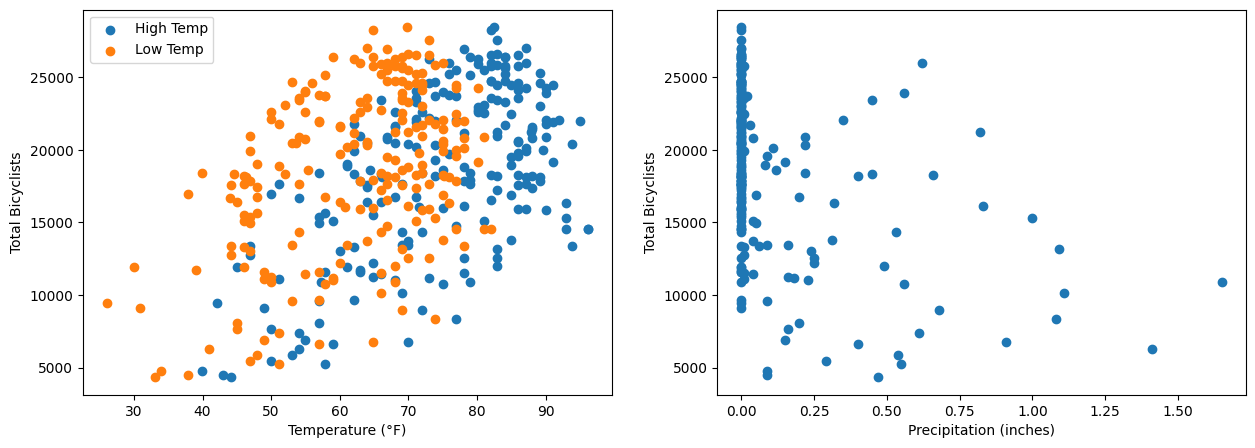

In [7]:
df = dataset_2[['High Temp', 'Low Temp', 'Precipitation']]
total = dataset_2['Total'].str.replace(',', '').astype(float)
df = pd.concat([df, total], axis=1)
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].scatter(x=list(df['High Temp']), y=list(df['Total']), label='High Temp')
ax[0].scatter(x=list(df['Low Temp']), y=list(df['Total']), label='Low Temp')
ax[1].scatter(x=list(df['Precipitation']), y=list(df['Total']))

# Set the labels for the x and y axes
ax[0].set_xlabel('Temperature (°F)')
ax[0].set_ylabel('Total Bicyclists')
ax[1].set_xlabel('Precipitation (inches)')
ax[1].set_ylabel('Total Bicyclists')
ax[0].legend()
plt.show()

Given that none of the weather features have a significant impact on the total number of bicyclists, and one of the features has already demonstrated a nonlinear relationship, we don’t anticipate that a model can be effectively trained to predict the total number of bicyclists. Nevertheless, we set aside 20% of our dataset as a test set and used the remaining 80% to train an initial Linear Regression model and then multiple higher order Polynomial Regression models. To ensure the features were on the same scale we normalized the training and testing data to their respective means and standard deviations. 5-fold cross-validation was used to evaluate the performance of each model. In short, this means that the training data is split into 5 subsets where four subsets are used to train the model and the remaining subset is used to evaluate the model. This process is repeated 5 times and each time a different subset is used to validate the model. The average mean squared error (MSE) is calculated during each iteration and averaged to represent the model’s overall validation MSE. Polynomials of degrees ranging from 1 to 5 were fit to the dataset using this process. 


#### Polynomial Regression

In [8]:
#Function to fit a polynomial model based on degree it receives
def fit_polynomial_model(X_train, y_train, degree):
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    model_dict = {'w': model.coef_, 'b': model.intercept_, 'poly': poly}
    return model_dict

#Calculates MSE for polynomial models
def error(X, y, model):
    poly = model['poly'] #Get polynomial features object stored in dictionary
    X_poly = poly.transform(X) #Fit data to polynomial features
    w = model['w'] #Pulls model coefficients from dictionary
    b = model['b'] #Pulls y-intercept from dictionary
    y_pred = X_poly.dot(w) + b #Takes dot product to get predictions
    mse = mean_squared_error(y, y_pred)
    return mse

df = dataset_2[['High Temp', 'Low Temp', 'Precipitation', 'Total']]
X = np.array(df[['High Temp', 'Low Temp','Precipitation']])
y = np.array(df['Total'].apply(lambda x: str(x).replace(',', '')).astype(float))

scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) #Normalizes data according to mean and standard deviation

#Moves 80% of data into a training set and the remaining 20% into a test set. Shuffles data by default 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 3)

kf = KFold(n_splits=5, shuffle=True, random_state=3) #Creates 5 fold cross validation object
degrees = range(1,6) #List of degrees to test_size

#Lists to store the training MSE and validation MSE of each model
MSE_Training = []
MSE_Validation = []

MODEL = [] #Stores dictionary of models

for degree in degrees:
    mse_fold_tr = []
    mse_fold_v = []
    for train_index, val_index in kf.split(X_train):
        X_fold_train, X_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_val = y_train[train_index], y_train[val_index]
        
        model_dict = fit_polynomial_model(X_fold_train, y_fold_train, degree) #Stores necessary information to reconstruct model

        #Appends training and validation MSE of current fold to lists
        mse_fold_tr.append(error(X_fold_train,y_fold_train,model_dict))  
        mse_fold_v.append(error(X_val,y_val,model_dict))

    #Averages list containing training and validation MSEs of each fold 
    MSE_Training.append(np.mean(mse_fold_tr)) 
    MSE_Validation.append(np.mean(mse_fold_v))
    
    MODEL.append(model_dict) 

In [9]:
print(f"Max number of total crossings recorded in a day: {max(y)}")
MSE_Training = np.round(MSE_Training)
MSE_Validation = np.round(MSE_Validation)
data_dict = {
    'Linear': np.hstack([MSE_Training[0], MSE_Validation[0]]),
    'Quadratic': np.hstack([MSE_Training[1], MSE_Validation[1]]),
    'Cubic': np.hstack([MSE_Training[2], MSE_Validation[2]]),
    'Quartic': np.hstack([MSE_Training[3], MSE_Validation[3]]),
    'Quintic': np.hstack([MSE_Training[4], MSE_Validation[4]])
}
df = pd.DataFrame(data_dict, index=['Training MSE', 'Validation MSE'])
df

Max number of total crossings recorded in a day: 28437.0


,Linear,Quadratic,Cubic,Quartic,Quintic
Training MSE,15755317.0,13090047.0,11089129.0,11033431.0,1.136544e+08
Validation MSE,16544809.0,19815996.0,89413268.0,264020562.0,3.584206e+13


Given that the maximum value of total recorded bicyclists in a day was 28,437, it's safe to assume that all of these models performed poorly. The best tested model was Linear (d = 1) and it achieved a training MSE of 15,755,317 and a validation MSE of 16,544,809. As we progress to higher order polynomials we see that the validation MSE increases exponentially and the training MSE slowly decrements until the Quartic model (d = 4). These results suggest that the decrease in training MSE is not a reflection of performance improvement but rather an indication of overfitting. This means that the models are compromising their ability to generalize well to unseen data in order to better represent the training data. 

Since the Linear model was the best tested model, we can now evaluate its performance on the 20% of our dataset that we held out to establish a baseline for comparison. This is unseen data, so it simulates the model’s performance in the real world. 

In [10]:
#Using best model on test set 
poly = (MODEL[0])['poly']
X_poly = poly.transform(X_test)
w = (MODEL[0])['w']
b = (MODEL[0])['b']
y_pred = X_poly.dot(w) + b
mse = mean_squared_error(y_test, y_pred)
print(f"MSE Test: {mse}")

MSE Test: 17780815.43915036


#### Random Forest Regression
Our final experiment was conducted using a slightly more sophisticated model, Random Forest Regression. This model involves repetitive sampling of the data and constructing decision trees based on a selected subset of the features. The final prediction is made by averaging the predictions of all the decision trees. Random Forest Regression may be better suited to answer this question than Linear Regression because it is able to capture more complex relationships between feature variables and a target variable. It may overcome the non-linear nature of the Precipitation data shown in the scatter plot.

One of the advantages Random Forest Regression has over Linear and Polynomial Regression is its flexibility to account for a larger number of features. To capitalize on this, additional features were extracted from the timestamps of the data and the day of week column. The timestamps were of the format “Oct-8” so a new column was made to represent the month numerically and a new column was made to represent the day of the month. The day of week column was of the format “Monday” so it was one hot encoded to represent a categorical feature. 

In [11]:
df = dataset_2
month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
              "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}
day_dict = {"Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6, "Sunday":7}
df['Month'] = df['Date'].str.split('-').str[1].map(month_dict)
df['Day_of_Month'] = df['Date'].str.split('-').str[0].astype(int)
df['Day_of_Week'] = df['Day'].map(day_dict)
df = df.drop(['Day','Date'], axis = 1)

X = np.array(df[['High Temp', 'Low Temp', 'Precipitation', 'Month', 'Day_of_Month', 'Day_of_Week']])

y = np.array(df['Total'].apply(lambda x: str(x).replace(',', '')).astype(float))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

model = RandomForestRegressor(random_state=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"MSE Test: {mse}")

MSE Test: 6908169.414555814


#### Question 2 Final Answer 

Unfortunately, despite an 88% boost in performance, it still did not perform well enough to conclude that the next day’s weather forecast can be used to predict the total number of bicyclists that day. 

## Question 3
**Can you use this data to predict what day (Monday to Sunday) is today based on the number of bicyclists on the bridges?**

This question differs from question 2 in the sense that we are now trying to predict a discrete variable rather than a continuous one. Therefore classification analysis is the correct approach to determine whether or not we can predict day of week based on the number of bicyclists on the bridge. Given that our dataset only contains 214 datapoints, each class would only have roughly 30 samples. This means that regardless of what approach we take, there is a high risk that our model will fall victim to overfitting the training data. It’s also important to note that this is a difficult task even with sufficient data. Realistically speaking, determining whether a day is a weekend or a weekday based on a city’s bike traffic shouldn’t be hard, but separating between traffic level on Mondays and traffic level on Tuesdays? That adds a significant degree of complexity for the model to overcome. 

We will start by visualizing the data to see if there is a large enough difference between day to day bike traffic during the week. This will give us a better idea of the results we should expect to see from the classification models we train. 

Since we have an equal number of examples of each class, we can use an accuracy score rather than an F1 score to evaluate model performance. Accuracy score is simply the percentage by which a model is able to correctly classify a sample of features. On the other hand, F1 score combines precision and recall to account for a majority class in the training data. Since we have an equal chance of predicting each class correctly, an F1 score is not necessary.

#### Normalized Breakdown of Bridge Activty by Day
In order to create the figure below, we normalized the counts for each bridge by dividing the count for each day by the sum of the counts for that bridge across all days. This creates a proportion of total count for each day and each bridge. The figure shows that all bridges generally follow the same weekly pattern of relative activity. The activity of all bridges peaks on Wednesday and begins to drop off for the remaining days of the week. Based on these results, it's highly unlikely that the daily total crossings for each bridge can be used to predict the day of the week. 


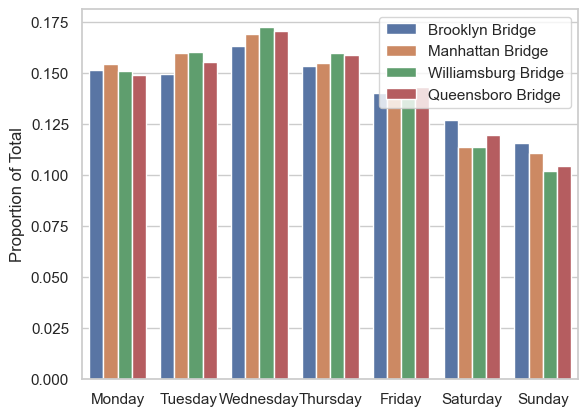

In [12]:
dataset_2 = pd.read_csv('NYC_Bicycle_Counts_2016.csv')
df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge']]
df = df.apply(lambda x: x.str.replace(',', '')).astype(float) 
df['Day'] = dataset_2['Day'] #Add in day column after numeric columns are stripped of commas and cast as floats
totals = df.groupby('Day').sum().reset_index() #Get each bridge's total crossings for each day of the week

numeric_cols = totals.select_dtypes(include=[np.number]) 
norm_cols = numeric_cols.div(numeric_cols.sum())
df_norm = pd.concat([norm_cols, totals[totals.columns.difference(numeric_cols.columns)]], axis=1)

#Reorders dataframe so that days appear in sequential order in bar plot 
sort_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_norm['Day'] = pd.Categorical(df_norm['Day'], categories=sort_order, ordered=True)
df_norm = df_norm.sort_values('Day')

#Restructures shape of dataframe so it can be directly passed to Seaborn's bar plot function
df_norm = pd.melt(df_norm, id_vars=['Day'], var_name='Bridge', value_name='Proportion of Total')

sns.set(style="whitegrid")
fig =  sns.barplot(x="Day", y="Proportion of Total", hue="Bridge", data=df_norm)
plt.legend(loc='upper right')
fig.set_xlabel('')
plt.show()


#### Multinomial Naive Bayes 
Given that we are limited to only 30 examples per class, a Multinomial Naive Bayes classification model was chosen to establish a baseline accuracy for comparison. This choice was made due to the model’s simplicity and the concern of overfitting the training data. Naive Bayes classifiers are considered simple because they make an assumption of conditional independence between features. This means that knowing a class and a single feature should not be enough to draw any conclusions about the other features.  The algorithm is simple because it estimates the likelihood of a class given all features by multiplying the probabilities of each individual feature being of the class. This is Bayes Theorem. The Naive in Naive Bayes refers to the fact that this is only made possible under the assumption of conditional independence. This model is expected to perform poorly because our analysis in question 1 showed that the Manhattan Bridge traffic is conditionally dependent on the Brooklyn Bridge traffic. 

In [13]:
df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge']]
X = df.apply(lambda x: x.str.replace(',', '')).astype(float)
y = dataset_2['Day']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

kf = KFold(n_splits=5, shuffle=True, random_state=3)
mnb_acc_score = []

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    mnb = MultinomialNB()
    mnb.fit(X_fold_train, y_fold_train)

    y_pred = mnb.predict(X_val)
    kfold_acc_score = accuracy_score(y_val, y_pred)*100
    mnb_acc_score.append(kfold_acc_score)

print(f"Naive Bayes Accuracy Score: {np.mean(mnb_acc_score):.2f}%")

Naive Bayes Accuracy Score: 22.82%


#### Multinomial Logistic Regression

The next model we trained was Multinomial Logistic Regression. Given the fact that the bridges generally follow the same weekly pattern, this model may be applicable to determine the day of the week from daily total crossings on each bridge. The name Logistic Regression is derived from the fact that the model involves predicting the logarithm of the odds, or log odds, of an outcome based on a linear combination of the features. The logistic function is then used to map the log odds into a probability. This method is useful because features tend to vary more linearly with log odds than they do with probabilities. The bar plot is an indication that there is a general correlation between our features as a whole and the day of week. This is a cue that we may see an improvement in performance from our baseline model.  Despite this, it's difficult to separate similariteis between classes. For example, relative activity levels of each bridge are very similar on Mondays, Tuesdays, and Thursdays. Another challenge this model will have to overcome is multicollinearity. This occurs when features are highly correlated with each other and the model has no way of identifying which feature is responsible for an impact on the dependent variable. Our analysis in question 1 determined that there is an extremely strong correlation between the activity on the Williamsburg Bridge and activity on the Queensboro bridge. 

In [14]:
df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge']]
X = df.apply(lambda x: x.str.replace(',', '')).astype(float) 
y = dataset_2['Day']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=3)

kf = KFold(n_splits=5, shuffle=True, random_state=3)
mlr_acc_score = []

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    mlr = LogisticRegression(multi_class='multinomial')
    mlr.fit(X_fold_train, y_fold_train)
    
    y_pred = mlr.predict(X_val)
    mlr_score = accuracy_score(y_val, y_pred)*100
    mlr_acc_score.append(mlr_score)

print(f"Logistic Regression Accuracy Score: {np.mean(mlr_acc_score):.2f}%")

Logistic Regression Accuracy Score: 25.75%


The slight improvement in accuracy score may be attributed to the fact that Logistic Regression models are generally less sensitive to multicollinearity than Naive Bayes models are to conditional dependence. This is due to the fact that a Logistic Regression model is able to mitigate the effects of multicollinearity to some degree by adjusting the weights of the features to account for the correlations. In contrast, there's nothing a Naive Bayes model can do to mitigate violation of conditional independence because its entire structure is contingent on the fact that the assumption is not violated. 


#### Multi-layer Perceptron Network/Question 3 Final Answer
It’s worth mentioning that this challenge of multicollinearity and conditional dependence in the dataset could have been overcome through a multi-layer perceptron network. This is a type of neural network that is commonly used for both classification and regression because it can capture extremely complex relationships between predictor variables and a target variable. It could overcome the challenge of multicollinearity and conditional dependence in the data set because it doesn’t require any assumptions of the data. The main drawback of neural networks is the fact that they require large amounts of data in order to learn the complex relationships. 30 examples of each class with only 4 features isn’t nearly enough to train a neural network. Therefore, our conclusion is that this data set alone cannot be used to predict day of week from the total number of bicyclists on the bridges.

In [15]:

df = dataset_2[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge']]
X = df.apply(lambda x: x.str.replace(',', '')).astype(float) #Cleaning Data
y = dataset_2['Day']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

kf = KFold(n_splits=5, shuffle=True, random_state=3)

mlp_acc_score = []
mlp_acc_score2 = []

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', solver='adam', max_iter=500, random_state=3)
    mlp2 = MLPClassifier(hidden_layer_sizes=(10,5), activation='relu', solver='adam', max_iter=500, random_state=3)

    mlp.fit(X_fold_train, y_fold_train)
    mlp2.fit(X_fold_train, y_fold_train)

    y_pred = mlp.predict(X_val)
    mlp_score = accuracy_score(y_val, y_pred)*100
    mlp_acc_score.append(mlp_score)

    y_pred2 = mlp2.predict(X_val)
    mlp_score2 = accuracy_score(y_val, y_pred2)*100
    mlp_acc_score2.append(mlp_score2)

print(f"MLP (1 hidden layer with 5 Neurons) Accuracy Score: {np.mean(mlp_acc_score):.2f}%")
print(f"MLP (2 hidden layers with 10 and 5 Neurons respectively) Accuracy Score: {np.mean(mlp_acc_score2):.2f}%")

/Users/shaanchanchani/opt/anaconda3/envs/Hack/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP (1 hidden layer with 5 Neurons) Accuracy Score: 15.80%
MLP (2 hidden layers with 10 and 5 Neurons respectively) Accuracy Score: 14.05%
